In [110]:
# Gradient Descent -> Article and Coding Example
# Neural Network Review
# How to update weights? Backprop
# Chain Rule
# Explanation by calculus
# Coding Example

In [ ]:
# https://towardsdatascience.com/gradient-descent-algorithm-a-deep-dive-cf04e8115f21

In [2]:
import numpy as np
from matplotlib import pyplot as plt

In [177]:
# func = lambda x: x**2 - 4*x + 1
# grad = lambda x: 2*x - 4

func = lambda x: x**4 - 2*x**3 + 2
grad = lambda x: 4*x**3 - 6*x**2

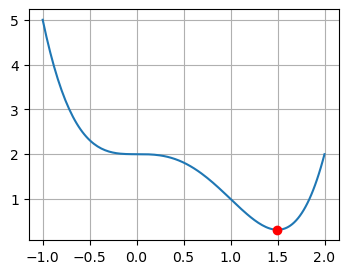

In [189]:
## plot function

fig, ax = plt.subplots(figsize=(4, 3))

# x = np.linspace(-10, 10, 150)
x = np.linspace(-1, 2, 150)
y = func(x)

plt.plot(x, y)
plt.plot(x[np.argmin(y)], np.min(y), 'ro')
plt.grid('on')

In [179]:
## task: find minima of function using grad descent

In [190]:
init_x = -1.0
learning_rate = 0.1
steps = 250

grads = []
costs = []
x_vals = []

x = init_x
for step in range(steps+1):
    costs.append(func(x))
    grads.append(grad(x))
    x_vals.append(x)
    x -= learning_rate*grads[-1]

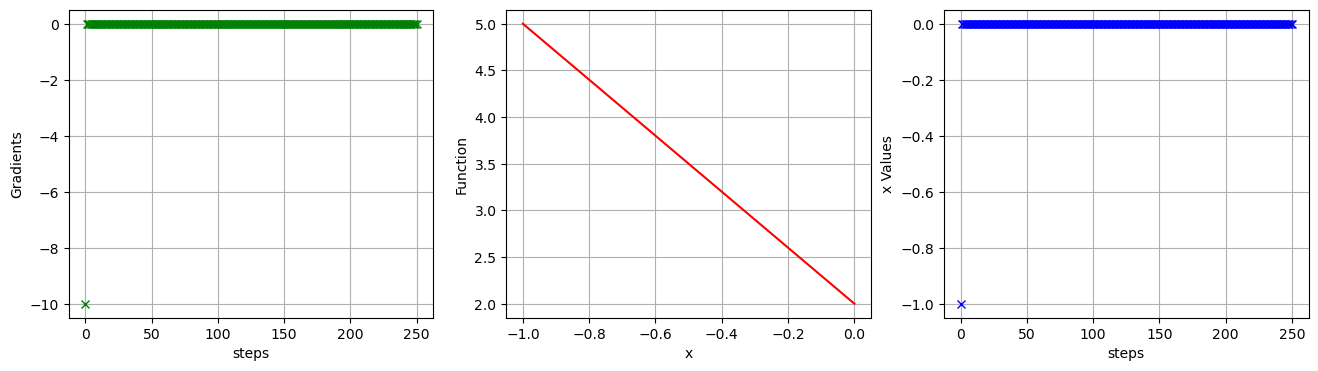

In [191]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

ax[0].plot(range(len(x_vals)), grads, "gx")
ax[0].set_ylabel('Gradients')
ax[0].set_xlabel('steps')
ax[0].grid('on')

ax[1].plot(x_vals, costs, "r")
ax[1].set_ylabel('Function')
ax[1].set_xlabel('x')
ax[1].grid('on')

ax[2].plot(range(len(x_vals)), x_vals, "bx")
ax[2].set_ylabel('x Values')
ax[2].set_xlabel('steps')
ax[2].grid('on')

In [ ]:
# https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/micrograd/micrograd_lecture_first_half_roughly.ipynb
# https://www.youtube.com/playlist?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ

In [8]:
## Backprop:
### chain rule
### loss function


# f(x) = y -> z

In [9]:
import math
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph

In [10]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
          # if this value is a result of some operation, create an op node for it
          dot.node(name = uid + n._op, label = n._op)
          # and connect this node to it
          dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [16]:
class Value:
  
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
  
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
    
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
    
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
    
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
      
        return out
  
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
    
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
    
        return out
  
    def backward(self):
    
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [198]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

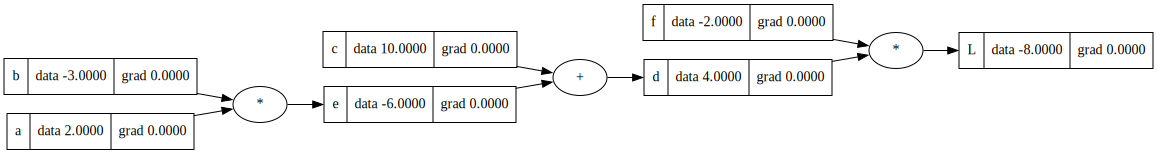

In [199]:
draw_dot(L)

In [196]:
# dL/dL = 1

# y = x
# dy/dx = 1
# L.grad = 1

# L = d*f
# dL/dd = f
# dL/df = d

# z = w*a + b
# dz/dw = a
# dz/da = w
# dz/db = 1

# d.grad = -2
# f.grad = 4

# d = c + e
# dd/dc = 1
# dd/de = 1

# dL/dc = dL/dd * dd/dc
# dL/de = dL/dd * dd/de

# c.grad = d.grad
# e.grad = d.grad

# e = a*b
# de/db = a
# de/da = b

# dL/db = dL/de * de/db
# dL/da = dL/de * de/da

In [146]:
# L.grad = 1

# L = f*d
# dL/dd = f = -2
# dL/df = d

# f.grad = 4
# d.grad = -2

# dL/dc = dL/dd * dd/dc

# d = c + e
# dd/dc = 1
# dd/de = 1

# c.grad = -2
# e.grad = -2

# dL/db = dL/de * de/db
# dL/da = dL/de * de/da

# e = b*a
# de/da = b
# de/db = a

In [35]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-8.0


In [37]:
def lol():
    
    h = 0.001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data
    
    print((L2 - L1)/h)

lol()

-3.9999999999995595


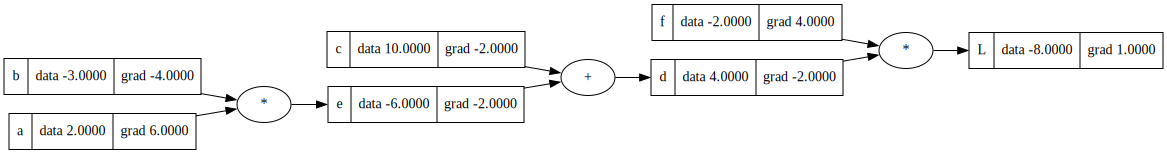

In [200]:
L.backward()
draw_dot(L)

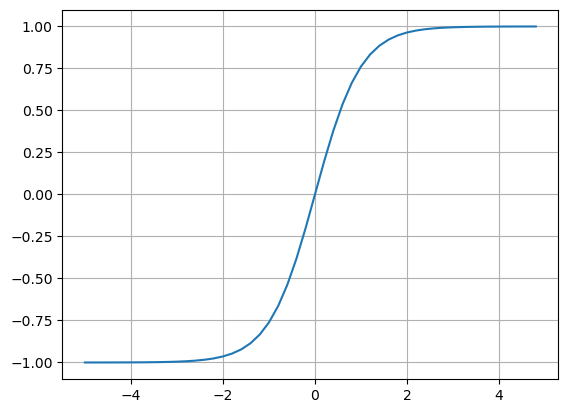

In [40]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [153]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

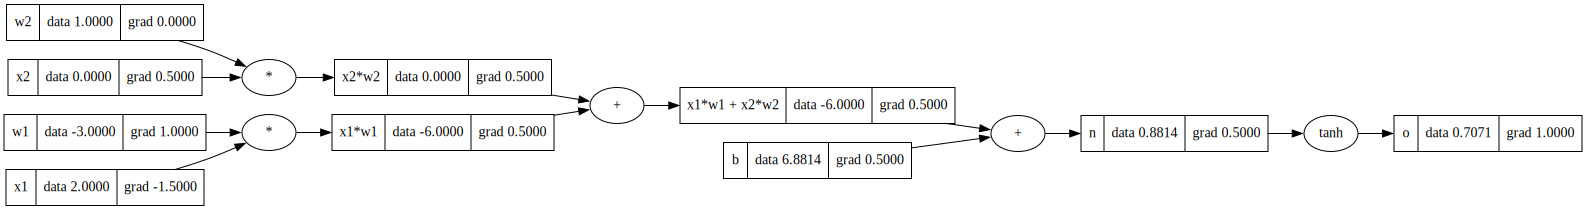

In [202]:
draw_dot(o)

In [201]:
o.backward()

In [100]:
o.grad = 1.0

In [105]:
1 - o.data**2

0.4999999999999999

In [101]:
o._backward()
o.grad

1.0

In [102]:
n._backward()
n.grad

0.4999999999999999

In [103]:
b._backward()
b.grad

0.4999999999999999

In [104]:
x1w1x2w2._backward()
x1w1x2w2.grad

0.4999999999999999

In [96]:
x2w2._backward()
x1w1._backward()

In [51]:
# x1.grad = w1.data * x1w1.grad
# w1.grad = x1.data * x1w1.grad

In [52]:
# x2.grad = w2.data * x2w2.grad
# w2.grad = x2.data * x2w2.grad

In [53]:
# x1w1.grad = 0.5
# x2w2.grad = 0.5

In [54]:
# x1w1x2w2.grad = 0.5
# b.grad = 0.5

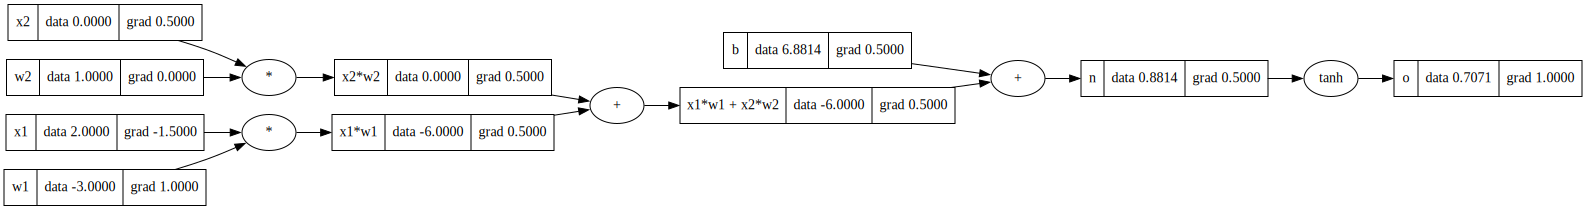

In [109]:
o.backward()
draw_dot(o)